In [4]:
from keras.layers import TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization
from keras import models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense,Flatten, LSTM
import keras
from tensorflow.keras.callbacks import EarlyStopping
import pickle
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd
from PIL import Image
import os
import cv2
import os
import math

In [ ]:
def data_load_function_10frames(directory):
	count = 0
	frames=[]
	labels = []
	dirs = os.listdir(directory)
	for d in dirs :
		count = 0
		sub_dirs = os.listdir(os.path.join(directory,d))
		for sd in sub_dirs:
				files = os.listdir(os.path.join(directory,d, sd))
				for file in files :
					count += 1
					vid_name=file
					vid_dir_path=os.path.join(directory,d, sd) # to change
					frames_to_select=[]
					for l in np.arange(0,8):
							frames_to_select.append('frame%d.jpg' % l)
					vid_data=[]
					for frame in frames_to_select:
							try :
									image=Image.open(os.path.join(vid_dir_path,frame))
									image=image.resize((64, 64), Image.ANTIALIAS) 
									datu=np.asarray(image)
									normu_dat=datu/255
									vid_data.append(normu_dat)
							except :
									vid_data.append(np.zeros_like(normu_dat)) # it is like padding as not all videos conatin 300 frames
					vid_data=np.array(vid_data)
					frames.append(vid_data)
		labels.extend([d]*count)
	return np.array(frames), np.array(labels)

In [ ]:
directory = '/content/drive/MyDrive/UCF50'
frames, labels = data_load_function_10frames(directory)

In [ ]:
len(frames)

3816

In [ ]:
# Reshaping tensors to confirm with the model we are going to train:
train_df = frames.reshape((3816, 8, 64, 64,1)) 

In [ ]:
labels

array(['YoYo', 'YoYo', 'YoYo', ..., 'GolfSwing', 'GolfSwing', 'GolfSwing'],
      dtype='<U10')

In [32]:
#labels
indx = {'Basketball':0, 'Biking':1, 'GolfSwing':2, 'YoYo':3}

In [ ]:
labels_ = []
for elt in labels :
  labels_.append(indx[elt])
labels = np.array(labels_)

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
encoded_labels = to_categorical(labels)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_df, encoded_labels, test_size = 0.2, shuffle = True, random_state = 0)

In [ ]:
model_cnlst = Sequential()
model_cnlst.add(TimeDistributed(Conv2D(128, (3, 3), strides=(1,1),activation='relu'),input_shape=(8, 64, 64,1)))
model_cnlst.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))
model_cnlst.add(TimeDistributed(Conv2D(64, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu')))
model_cnlst.add(TimeDistributed(MaxPooling2D(2,2)))
model_cnlst.add(TimeDistributed(BatchNormalization()))


model_cnlst.add(TimeDistributed(Flatten()))
model_cnlst.add(Dropout(0.2))

model_cnlst.add(LSTM(32,return_sequences=False,dropout=0.2)) # used 32 units

model_cnlst.add(Dense(64,activation='relu'))
model_cnlst.add(Dense(32,activation='relu'))
model_cnlst.add(Dropout(0.2))
model_cnlst.add(Dense(4, activation='sigmoid'))
model_cnlst.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 8, 62, 62, 128)   1280      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 8, 60, 60, 64)    73792     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 8, 30, 30, 64)    0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 8, 28, 28, 64)    36928     
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 8, 26, 26, 32)    1

In [ ]:
y_train.shape

(3052, 4)

In [ ]:
from keras import optimizers
# Adding Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

#optimizer_new=optimizers.RMSprop(lr=0.01)
model_cnlst.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
# Training:
history_new_cnlst=model_cnlst.fit(x_train,y_train,batch_size=10,epochs=20,
                        validation_data=(x_test,y_test),
                       callbacks=early_stopping_callback)

Epoch 1/20
306/306 [==============================] - 37s 65ms/step - loss: 0.3772 - acc: 0.6412 - val_loss: 0.3113 - val_acc: 0.6623
Epoch 2/20
306/306 [==============================] - 18s 60ms/step - loss: 0.2538 - acc: 0.7690 - val_loss: 0.6375 - val_acc: 0.5013
Epoch 3/20
306/306 [==============================] - 18s 60ms/step - loss: 0.2040 - acc: 0.8218 - val_loss: 0.1694 - val_acc: 0.8599
Epoch 4/20
306/306 [==============================] - 18s 60ms/step - loss: 0.1722 - acc: 0.8529 - val_loss: 0.1819 - val_acc: 0.8521
Epoch 5/20
306/306 [==============================] - 19s 61ms/step - loss: 0.1292 - acc: 0.8994 - val_loss: 0.1095 - val_acc: 0.9241
Epoch 6/20
306/306 [==============================] - 20s 65ms/step - loss: 0.0937 - acc: 0.9335 - val_loss: 0.1258 - val_acc: 0.9254
Epoch 7/20
306/306 [==============================] - 19s 61ms/step - loss: 0.0668 - acc: 0.9531 - val_loss: 0.1212 - val_acc: 0.9162
Epoch 8/20
306/306 [==============================] - 19s 61ms

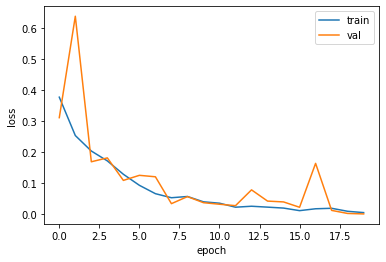

In [ ]:
# visualize the models loss
plt.plot(history_new_cnlst.history['loss'])
plt.plot(history_new_cnlst.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper right')
plt.show()

In [ ]:
# Saving your Model
model_cnlst.save('VidClass.h5')

In [2]:
model = load_model('/content/drive/MyDrive/VidClass.h5')

In [51]:
def predict_on_video(video_read_path) :
    cap=cv2.VideoCapture(video_read_path)
    cap.set(cv2.CAP_PROP_FPS, 1)
    frameRate=cap.get(5)
    x=1
    count=0
    vid_data = []
    while(cap.isOpened()) :
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            frame_grey=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            cv2.imwrite('./frame.jpg', frame_grey)
            image=Image.open('./frame.jpg')
            image=image.resize((64, 64), Image.ANTIALIAS) 
            datu=np.asarray(image)
            normu_dat=datu/255
            vid_data.append(normu_dat)
            count += 1
    cap.release()
    if count < 8 :
      marge = 8 - count 
      for i in range(marge) :
        vid_data.append(np.zeros_like(normu_dat))
    elif count > 8 :
      vid_data = vid_data[:8]
    pred = model.predict(np.expand_dims(vid_data, axis = 0))[0]
    pred = np.argmax(pred)
    label = list(indx.keys())[pred]
    return np.array(vid_data), label

In [52]:
data, pred = predict_on_video("/content/$RCBZB06.avi")

In [48]:
pred

'Basketball'

In [54]:
from google.colab.patches import cv2_imshow